In [ ]:
!pip install datasets matplotlib seaborn
from datasets import load_dataset
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.2 MB/s eta 0:00:00


In [ ]:
# Load the dataset
dataset = load_dataset("OleehyO/latex-formulas", "cleaned_formulas")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.72k [00:00<?, ?B/s]

train-00000-of-00006.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

train-00001-of-00006.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00002-of-00006.parquet:   0%|          | 0.00/439M [00:00<?, ?B/s]

train-00003-of-00006.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

train-00004-of-00006.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

train-00005-of-00006.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/552340 [00:00<?, ? examples/s]

In [ ]:
# Extract the LaTeX expressions (assuming they are under the "formula" key)
latex_texts = [entry["latex_formula"] for entry in dataset["train"]]

# Function to clean LaTeX formulas
def clean_latex(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s\\\^\_\{\}\+\-\*/=\(\)\[\]\.,∑∫αβγθ∞≤≥<>]', '', text)
    return text

# Apply cleaning to all LaTeX expressions
cleaned_texts = list(set(clean_latex(text) for text in latex_texts))  # Remove duplicates

# Convert to a Pandas DataFrame
df = pd.DataFrame(cleaned_texts, columns=["latex_formula"])

# Save cleaned data
df.to_csv("cleaned_latex_formulas.txt", index=False, header=False)
print(f" Extracted and cleaned {len(cleaned_texts)} unique LaTeX formulas!")


 Extracted and cleaned 519348 unique LaTeX formulas!


In [ ]:
# Tokenization Approaches
character_tokenizer = Tokenizer(models.BPE())
word_tokenizer = Tokenizer(models.BPE())
subword_tokenizer = Tokenizer(models.BPE())
wordpiece_tokenizer = Tokenizer(models.WordPiece(unk_token="<UNK>"))

# Configure Pre-tokenizers
character_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
word_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
subword_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
wordpiece_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Train Tokenizers
bpe_trainer = trainers.BpeTrainer(vocab_size=5000, min_frequency=2, special_tokens=["<PAD>", "<UNK>", "<BOS>", "<EOS>"])
wordpiece_trainer = trainers.WordPieceTrainer(vocab_size=5000, min_frequency=2, special_tokens=["<PAD>", "<UNK>", "<BOS>", "<EOS>"])

character_tokenizer.train(["cleaned_latex_formulas.txt"], bpe_trainer)
word_tokenizer.train(["cleaned_latex_formulas.txt"], bpe_trainer)
subword_tokenizer.train(["cleaned_latex_formulas.txt"], bpe_trainer)
wordpiece_tokenizer.train(["cleaned_latex_formulas.txt"], wordpiece_trainer)

# Save Tokenizers
character_tokenizer.save("character_tokenizer.json")
word_tokenizer.save("word_tokenizer.json")
subword_tokenizer.save("subword_tokenizer.json")
wordpiece_tokenizer.save("wordpiece_tokenizer.json")

print("All tokenizers trained and saved!")


All tokenizers trained and saved!


In [ ]:
# Load Trained Tokenizers
character_tokenizer = Tokenizer.from_file("character_tokenizer.json")
word_tokenizer = Tokenizer.from_file("word_tokenizer.json")
subword_tokenizer = Tokenizer.from_file("subword_tokenizer.json")
wordpiece_tokenizer = Tokenizer.from_file("wordpiece_tokenizer.json")

# Evaluate Tokenization Efficiency
def evaluate_tokenizer(tokenizer, formulas):
    total_tokens = 0
    oov_count = 0
    for formula in formulas:
        encoded = tokenizer.encode(formula)
        total_tokens += len(encoded.tokens)
        oov_count += sum(1 for token in encoded.tokens if token == "<UNK>")
    token_efficiency = total_tokens / len(formulas)
    oov_rate = (oov_count / total_tokens) * 100 if total_tokens > 0 else 0
    return tokenizer.get_vocab_size(), token_efficiency, oov_rate

# Compute Metrics
char_vocab, char_eff, char_oov = evaluate_tokenizer(character_tokenizer, cleaned_texts)
word_vocab, word_eff, word_oov = evaluate_tokenizer(word_tokenizer, cleaned_texts)
subword_vocab, subword_eff, subword_oov = evaluate_tokenizer(subword_tokenizer, cleaned_texts)
wordpiece_vocab, wordpiece_eff, wordpiece_oov = evaluate_tokenizer(wordpiece_tokenizer, cleaned_texts)


In [ ]:
# Display Metrics
print("\nTokenizer Evaluation:")
print(f"Character-based: Vocab={char_vocab}, Tokens/Formula={char_eff:.2f}, OOV={char_oov:.2f}%")
print(f"Word-based: Vocab={word_vocab}, Tokens/Formula={word_eff:.2f}, OOV={word_oov:.2f}%")
print(f"Subword-based (BPE): Vocab={subword_vocab}, Tokens/Formula={subword_eff:.2f}, OOV={subword_oov:.2f}%")
print(f"WordPiece-based: Vocab={wordpiece_vocab}, Tokens/Formula={wordpiece_eff:.2f}, OOV={wordpiece_oov:.2f}%")





Tokenizer Evaluation:
Character-based: Vocab=5000, Tokens/Formula=65.15, OOV=0.00%
Word-based: Vocab=5000, Tokens/Formula=61.48, OOV=0.00%
Subword-based (BPE): Vocab=5000, Tokens/Formula=65.15, OOV=0.00%
WordPiece-based: Vocab=5000, Tokens/Formula=61.69, OOV=0.00%


<ipython-input-44-5b1392f238d7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=tokens_per_formula, palette="coolwarm")


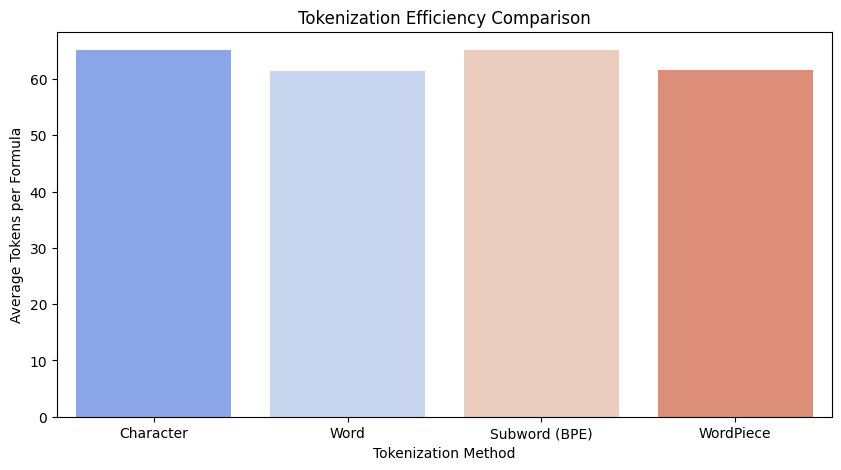

In [ ]:
# Visualization
plt.figure(figsize=(10, 5))
labels = ["Character", "Word", "Subword (BPE)", "WordPiece"]
tokens_per_formula = [char_eff, word_eff, subword_eff, wordpiece_eff]

sns.barplot(x=labels, y=tokens_per_formula, palette="coolwarm")
plt.xlabel("Tokenization Method")
plt.ylabel("Average Tokens per Formula")
plt.title("Tokenization Efficiency Comparison")
plt.show()



In [ ]:
tokenizer = Tokenizer.from_file("subword_tokenizer.json")
print(tokenizer.get_vocab())


{'}\\,.': 2271, '})[\\': 3334, '}},\\': 595, 'cong': 1055, 'Ġt': 244, 'TZ': 3214, 'lb': 4155, 'Ġ_{\\{': 4594, 'FD': 4460, 'Ġ': 88, 'Qf': 4911, '})+(\\': 3968, '^*)^': 2093, 'note': 2328, 'qu': 314, '-\\': 138, 'Ra': 3645, ')}_{\\': 922, 'jp': 2097, 'ikl': 4292, '_{_{(': 4922, '))>': 4252, '9': 22, 'NC': 1834, '63': 3270, '\\,=\\': 4020, 'sw': 2355, 'tn': 4277, '*(': 2364, 'Dw': 2464, 'k': 67, 'nV': 4126, 'pj': 3611, 'supseteq': 2224, 'str': 2257, 'KN': 3344, ',+}': 3782, 'limsup': 842, 'setminus': 590, ')}].\\': 4666, '62': 4645, '{{\\': 594, 'Ġ,{\\': 3447, 'Ġ-(': 974, 'Ġ[[': 2405, '}\\,,\\': 1018, ')_*': 2741, 'Ġan': 2398, 'bol': 484, 'dn': 1689, '){{\\': 3751, ']}_': 2692, 'Lf': 3248, 'dD': 3154, 'exp': 442, 'kb': 2345, 'suit': 3738, '^': 55, '100': 1384, 'theta': 197, '}{\\\\': 2351, '\\}=-': 4418, 'HK': 4907, '}}_{[': 4896, '_{\\': 128, ')}.\\': 578, '^{-}_{': 2293, '^-}{': 3639, '*}^{': 4473, '\\{\\{': 3869, 'rob': 2477, '))}^': 4396, '}},': 593, '13': 668, 'thing': 1990, 'ke': 16

In [ ]:
text = r"\sum_{n=1}^{\infty} \frac{1}{n^2} = \frac{\pi^2}{6}"
encoded = tokenizer.encode(text)
print("Tokens:", encoded.tokens)
print("Token IDs:", encoded.ids)


Tokens: ['Ġ\\', 'sum', '_{', 'n', '=', '1', '}^{\\', 'infty', '}', 'Ġ\\', 'frac', '{', '1', '}{', 'n', '^', '2', '}', 'Ġ=', 'Ġ\\', 'frac', '{\\', 'pi', '^', '2', '}{', '6', '}']
Token IDs: [89, 148, 92, 70, 24, 14, 245, 191, 84, 89, 109, 83, 14, 107, 70, 55, 15, 84, 116, 89, 109, 120, 187, 55, 15, 107, 19, 84]


In [ ]:
# Test sample
tokenizer = Tokenizer.from_file("wordpiece_tokenizer.json")


edge_cases = [
    r"\sum_{n=1}^{\infty} \frac{1}{n^2} = \frac{\pi^2}{6}",
    r"\int_{0}^{\infty} x^{s-1} e^{-x} dx = \Gamma(s)",
    r"\begin{array}{cc} a & b \\ c & d \end{array}"
]

for formula in edge_cases:
    tokens = tokenizer.encode(formula).tokens
    print(f"Formula: {formula}")
    print(f"Tokens: {tokens}\n")

Formula: \sum_{n=1}^{\infty} \frac{1}{n^2} = \frac{\pi^2}{6}
Tokens: ['\\', 'sum_', '{', 'n', '=', '1', '}^{\\', 'infty', '}', '\\', 'frac', '{', '1', '}{', 'n', '^', '2', '}', '=', '\\', 'frac', '{\\', 'pi', '^', '2', '}{', '6', '}']

Formula: \int_{0}^{\infty} x^{s-1} e^{-x} dx = \Gamma(s)
Tokens: ['\\', 'int_', '{', '0', '}^{\\', 'infty', '}', 'x', '^{', 's', '-', '1', '}', 'e', '^{-', 'x', '}', 'dx', '=', '\\', 'Gamma', '(', 's', ')']

Formula: \begin{array}{cc} a & b \\ c & d \end{array}
Tokens: ['\\', 'begin', '{', 'array', '}{', 'cc', '}', 'a', '<UNK>', 'b', '\\\\', 'c', '<UNK>', 'd', '\\', 'end', '{', 'array', '}']



In [ ]:
#test sample
tokenizer = Tokenizer.from_file("subword_tokenizer.json")
edge_cases = [
    r"\sum_{n=1}^{\infty} \frac{1}{n^2} = \frac{\pi^2}{6}",
    r"\int_{0}^{\infty} x^{s-1} e^{-x} dx = \Gamma(s)",
    r"\begin{array}{cc} a & b \\ c & d \end{array}"
]

for formula in edge_cases:
    tokens = tokenizer.encode(formula).tokens
    print(f"Formula: {formula}")
    print(f"Tokens: {tokens}\n")


Formula: \sum_{n=1}^{\infty} \frac{1}{n^2} = \frac{\pi^2}{6}
Tokens: ['Ġ\\', 'sum', '_{', 'n', '=', '1', '}^{\\', 'infty', '}', 'Ġ\\', 'frac', '{', '1', '}{', 'n', '^', '2', '}', 'Ġ=', 'Ġ\\', 'frac', '{\\', 'pi', '^', '2', '}{', '6', '}']

Formula: \int_{0}^{\infty} x^{s-1} e^{-x} dx = \Gamma(s)
Tokens: ['Ġ\\', 'int', '_{', '0', '}^{\\', 'infty', '}', 'Ġx', '^{', 's', '-', '1', '}', 'Ġe', '^{-', 'x', '}', 'Ġdx', 'Ġ=', 'Ġ\\', 'Gamma', '(', 's', ')']

Formula: \begin{array}{cc} a & b \\ c & d \end{array}
Tokens: ['Ġ\\', 'begin', '{', 'array', '}{', 'cc', '}', 'Ġa', 'Ġ', 'Ġb', 'Ġ\\\\', 'Ġc', 'Ġ', 'Ġd', 'Ġ\\', 'end', '{', 'array', '}']



In [ ]:
#test sample
tokenizer = Tokenizer.from_file("character_tokenizer.json")
edge_cases = [
    r"\sum_{n=1}^{\infty} \frac{1}{n^2} = \frac{\pi^2}{6}",
    r"\int_{0}^{\infty} x^{s-1} e^{-x} dx = \Gamma(s)",
    r"\begin{array}{cc} a & b \\ c & d \end{array}"
]

for formula in edge_cases:
    tokens = tokenizer.encode(formula).tokens
    print(f"Formula: {formula}")
    print(f"Tokens: {tokens}\n")

Formula: \sum_{n=1}^{\infty} \frac{1}{n^2} = \frac{\pi^2}{6}
Tokens: ['Ġ\\', 'sum', '_{', 'n', '=', '1', '}^{\\', 'infty', '}', 'Ġ\\', 'frac', '{', '1', '}{', 'n', '^', '2', '}', 'Ġ=', 'Ġ\\', 'frac', '{\\', 'pi', '^', '2', '}{', '6', '}']

Formula: \int_{0}^{\infty} x^{s-1} e^{-x} dx = \Gamma(s)
Tokens: ['Ġ\\', 'int', '_{', '0', '}^{\\', 'infty', '}', 'Ġx', '^{', 's', '-', '1', '}', 'Ġe', '^{-', 'x', '}', 'Ġdx', 'Ġ=', 'Ġ\\', 'Gamma', '(', 's', ')']

Formula: \begin{array}{cc} a & b \\ c & d \end{array}
Tokens: ['Ġ\\', 'begin', '{', 'array', '}{', 'cc', '}', 'Ġa', 'Ġ', 'Ġb', 'Ġ\\\\', 'Ġc', 'Ġ', 'Ġd', 'Ġ\\', 'end', '{', 'array', '}']



In [ ]:

#test sample
tokenizer = Tokenizer.from_file("word_tokenizer.json")
edge_cases = [
    r"\sum_{n=1}^{\infty} \frac{1}{n^2} = \frac{\pi^2}{6}",
    r"\int_{0}^{\infty} x^{s-1} e^{-x} dx = \Gamma(s)",
    r"\begin{array}{cc} a & b \\ c & d \end{array}"
]

for formula in edge_cases:
    tokens = tokenizer.encode(formula).tokens
    print(f"Formula: {formula}")
    print(f"Tokens: {tokens}\n")

Formula: \sum_{n=1}^{\infty} \frac{1}{n^2} = \frac{\pi^2}{6}
Tokens: ['\\', 'sum_', '{', 'n', '=', '1', '}^{\\', 'infty', '}', '\\', 'frac', '{', '1', '}{', 'n', '^', '2', '}', '=', '\\', 'frac', '{\\', 'pi', '^', '2', '}{', '6', '}']

Formula: \int_{0}^{\infty} x^{s-1} e^{-x} dx = \Gamma(s)
Tokens: ['\\', 'int_', '{', '0', '}^{\\', 'infty', '}', 'x', '^{', 's', '-', '1', '}', 'e', '^{-', 'x', '}', 'dx', '=', '\\', 'Gamma', '(', 's', ')']

Formula: \begin{array}{cc} a & b \\ c & d \end{array}
Tokens: ['\\', 'begin', '{', 'array', '}{', 'cc', '}', 'a', 'b', '\\\\', 'c', 'd', '\\', 'end', '{', 'array', '}']

